In [1]:
# # run this cell to get the merged_rnn csv file

# import pandas as pd
# import numpy as np

# merged_path = '../data/plankton-patrol/Plankton Patrol/Data/plank_Chesapeake_buoywater_merged.csv'
# data = pd.read_csv(merged_path)

# # merge columns from two datasets - they do not overlap
# data['Chlorophyll_Merged'] = data['Chlorophyll'].fillna(data['CHLA'])
# data = data.drop(columns=['Chlorophyll','CHLA'])
# data = data.rename(columns={'Chlorophyll_Merged': 'Chlorophyll'})

# data['Salinity_Merged'] = data['Salinity'].fillna(data['SALINITY'])
# data = data.drop(columns=['Salinity','SALINITY'])
# data = data.rename(columns={'Salinity_Merged': 'Salinity'})

# data['Wtemp_Merged'] = data['Temperature'].fillna(data['WTEMP'])
# data = data.drop(columns=['Temperature','WTEMP'])
# data = data.rename(columns={'Wtemp_Merged': 'Temperature'})

# data['DO_Merged'] = data['Oxygen'].fillna(data['DO'])
# data = data.drop(columns=['Oxygen','DO'])
# data = data.rename(columns={'DO_Merged': 'Oxygen'})

# data.to_csv('../data/plankton-patrol/Plankton Patrol/plank_Chesapeake_buoywater_merged_rnn.csv', index=False)

# The cells in this section are for data cleaning into hourly data:

Notes:
1. simple imputation techniques (mean, linear regression) are not too helpful
2. main issue is with a large percentage of missing data for certain columns ( > 95%)
    - the columns are important predictors and can't be removed
    - try to work with coarser datasets by looking at daily averages
3.  See https://kearnz.github.io/autoimpute-tutorials/ for autoimpute

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from autoimpute.imputations import MiceImputer, SingleImputer, MultipleImputer
from autoimpute.visuals import plot_md_locations, plot_md_percent

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Load the dataset
merged_path = '../data/plankton-patrol/Plankton Patrol//plank_Chesapeake_buoywater_merged_rnn.csv'
data = pd.read_csv(merged_path)

In [4]:
# create time column from sample_year, sample_month, sample_day, sample_hour, sample_minute, sample_second
data['Time'] = pd.to_datetime(dict(year=data.Sample_year,month= data.Sample_month,day=data.Sample_day,hour=data.Sample_hour,minute=data.Sample_minute,second=data.Sample_second))

In [5]:
# drop columns that are not needed for now (currents have extreme values, sample_* are reindexed as datetime)
# might drop more after test run)
data = data.drop(columns=['North surface currents','East surface currents','Sample_year', 'Sample_month', 'Sample_day','Sample_hour', 'Sample_minute', 'Sample_second','Wave period','Latitude','Longitude'])

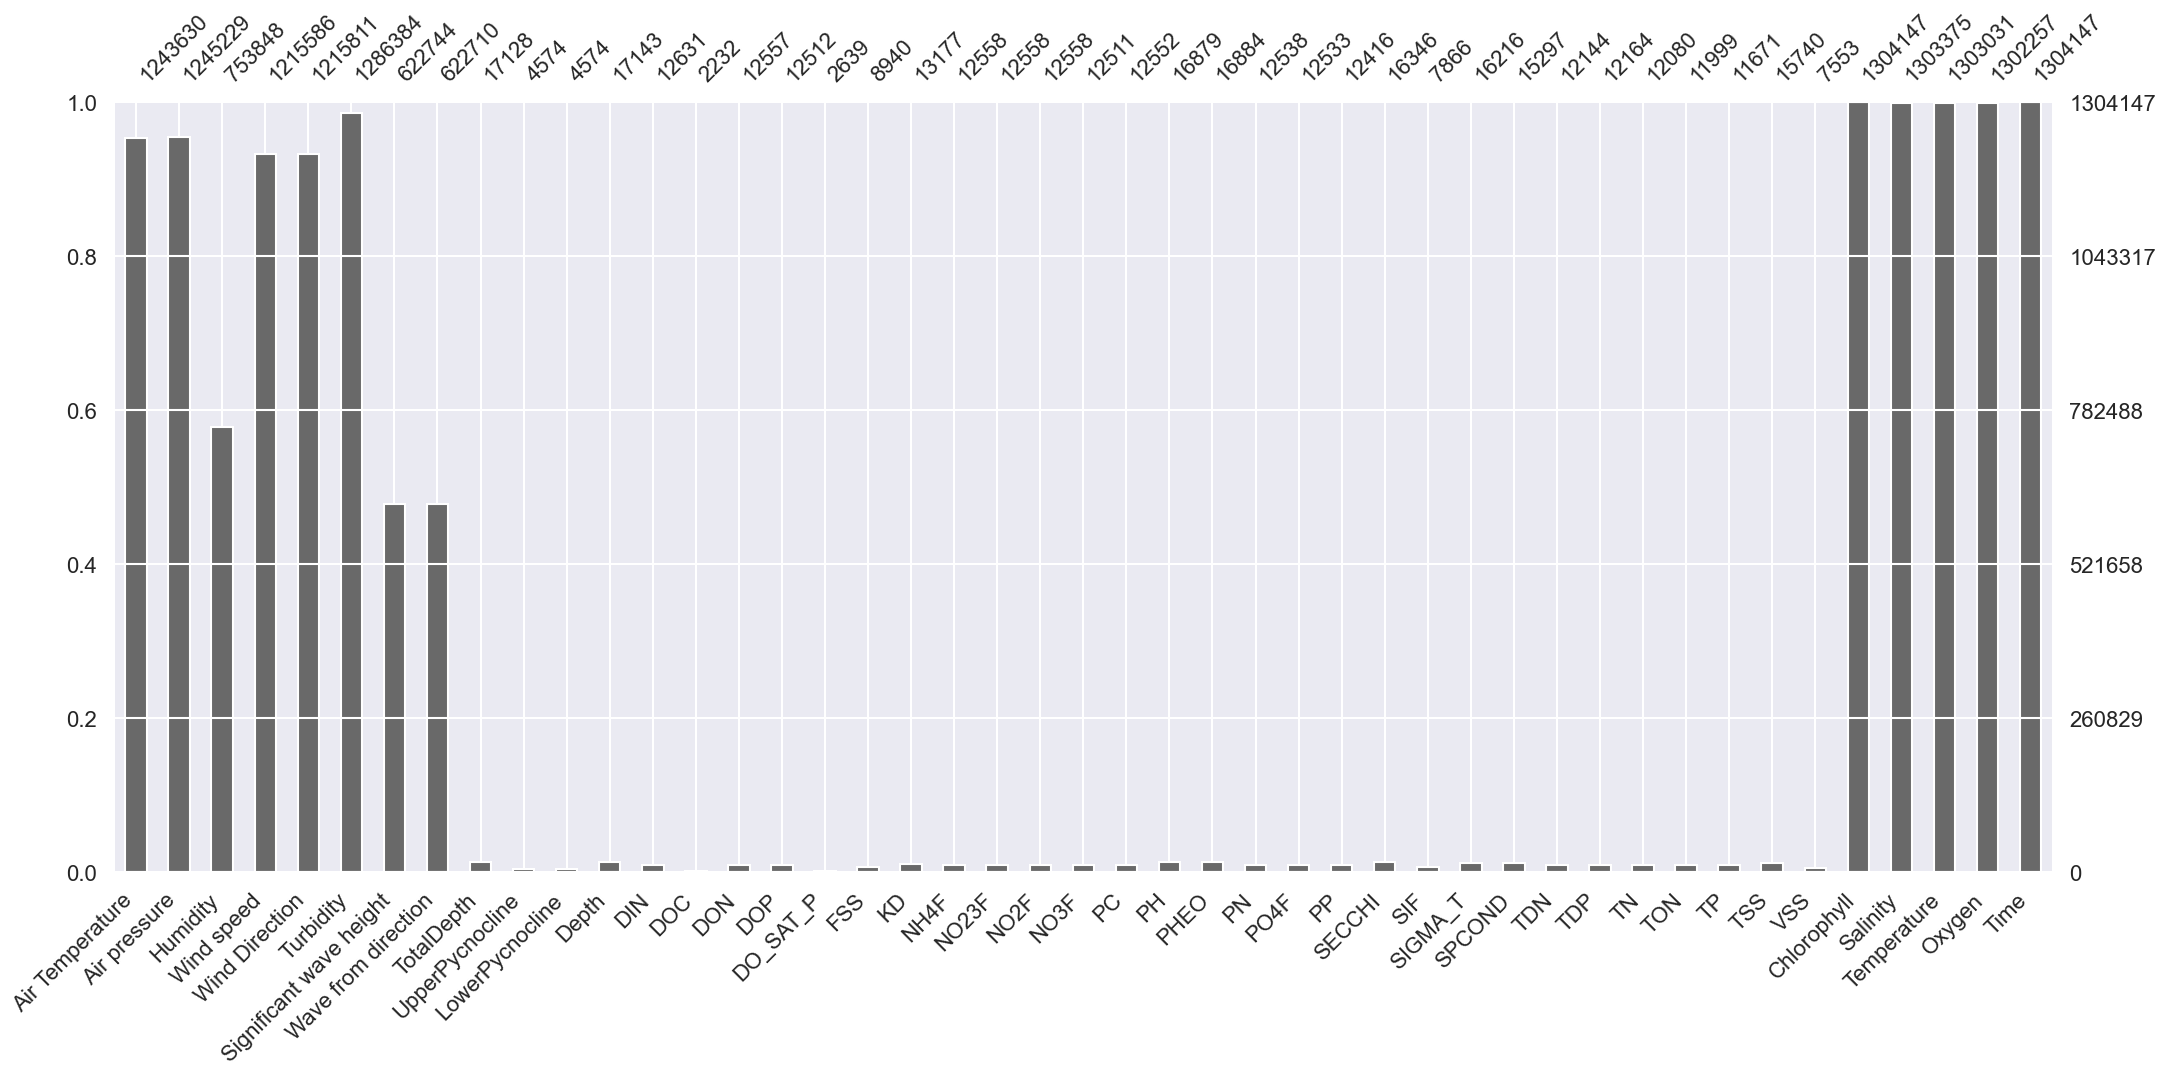

In [6]:
plot_md_percent(data)

In [7]:
# can't use the data as is, need to resample to hourly data
data = data.resample('h',on='Time').mean().dropna(how='all')

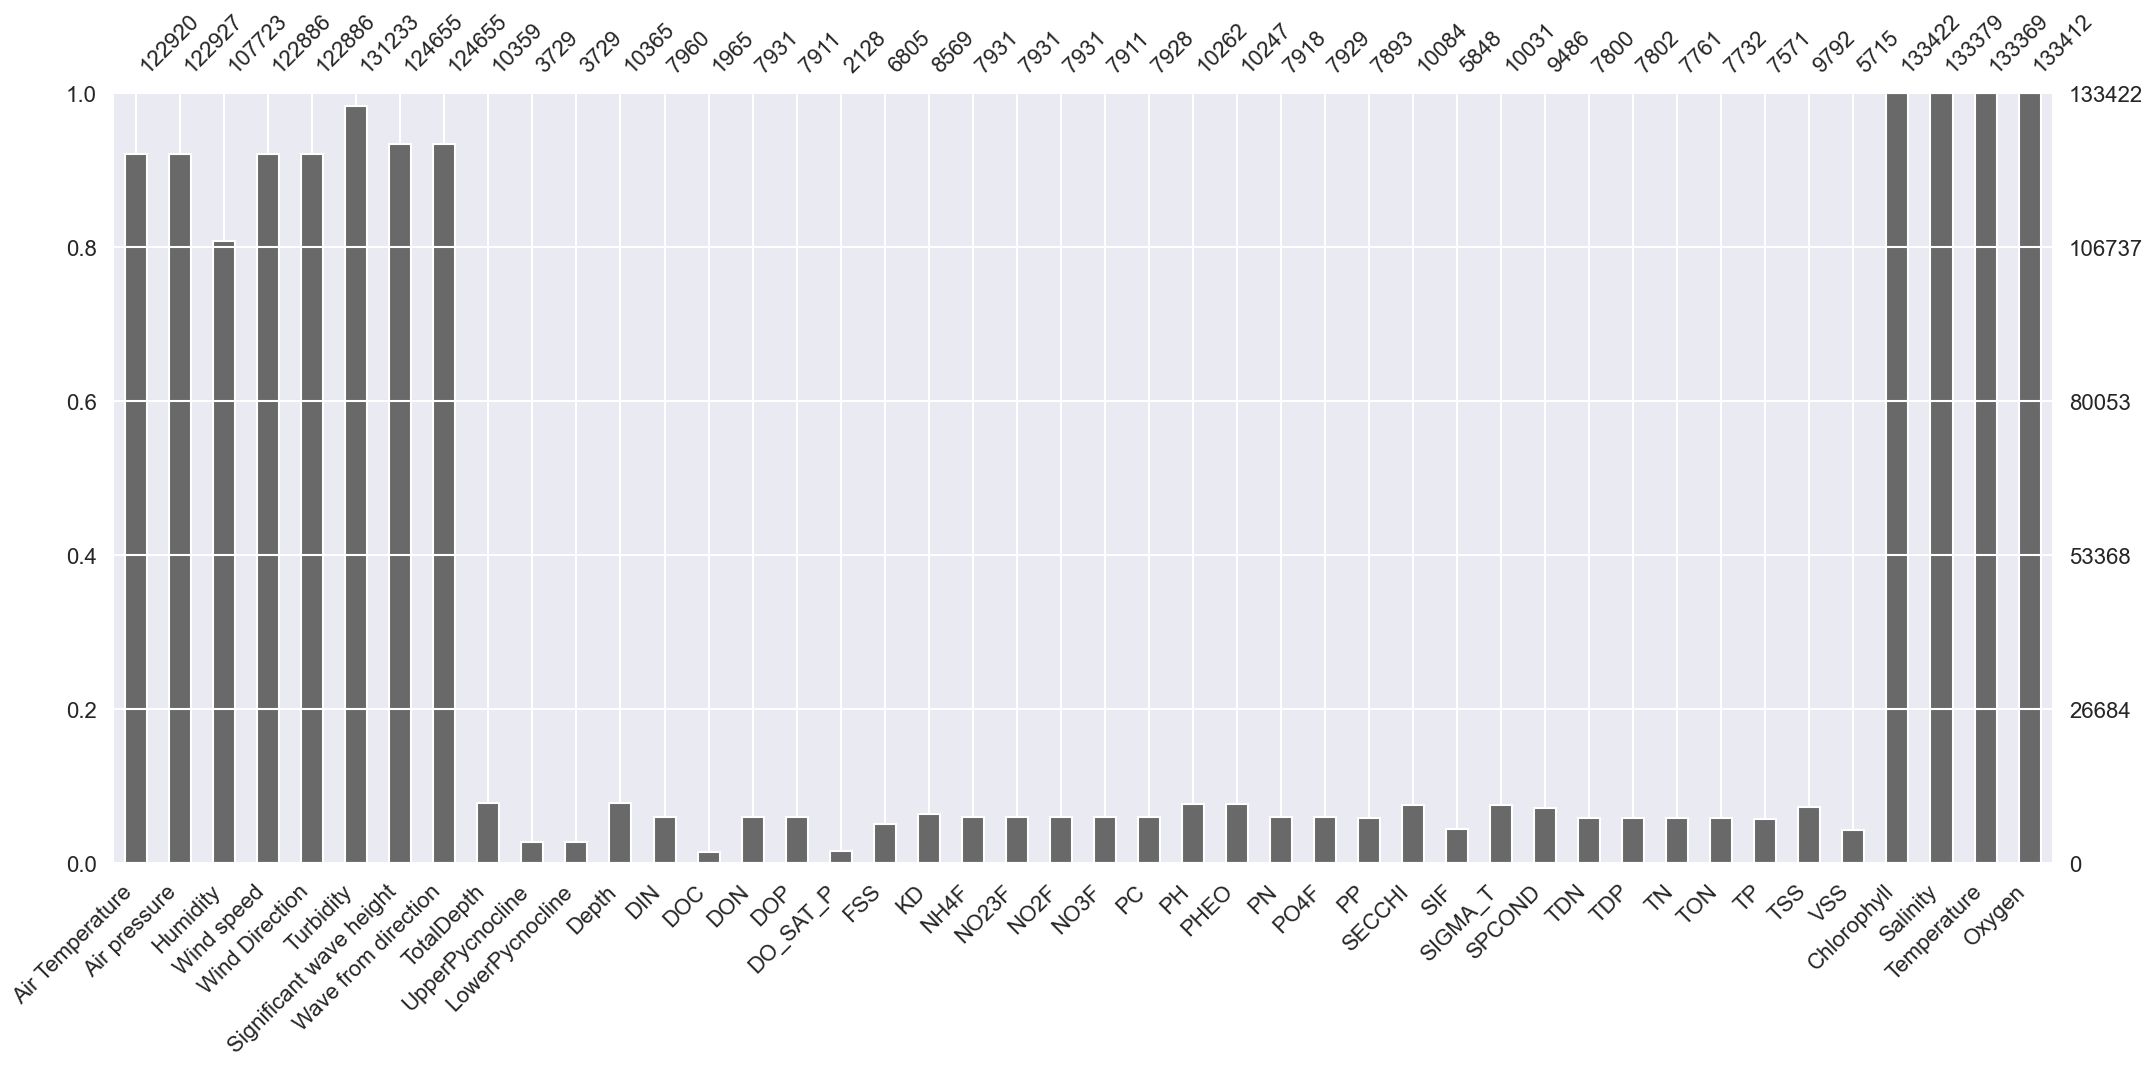

In [8]:
plot_md_percent(data)

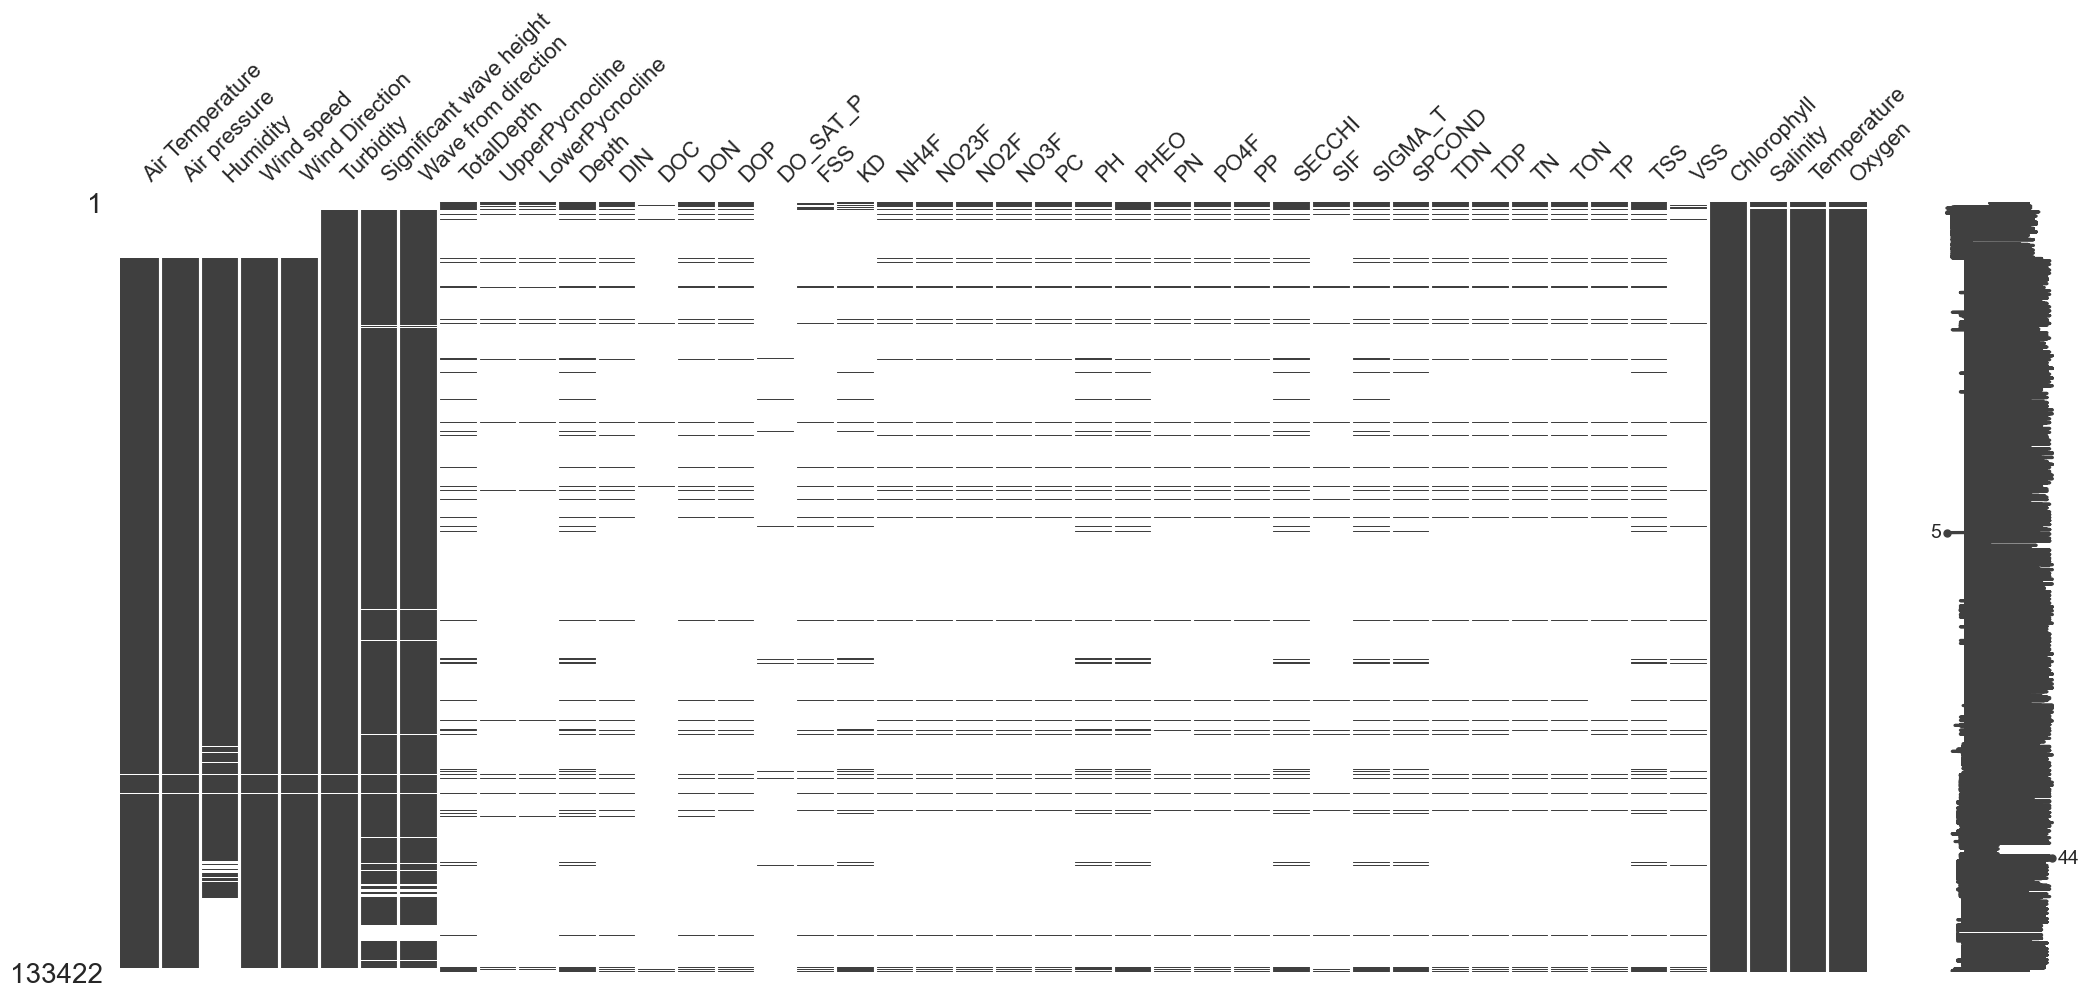

In [9]:
plot_md_locations(data)

In [10]:
data.to_csv('../data/plankton-patrol/Plankton Patrol/plank_Chesapeake_buoywater_merged_rnn_hourly.csv')

# Run this if you already have hourly data

In [11]:
import pandas as pd
import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from autoimpute.imputations import SingleImputer, MultipleImputer

In [12]:
# from tensorflow.python.client import device_lib
# def get_available_devices():
#      local_device_protos = device_lib.list_local_devices()
#      return [x.name for x in local_device_protos]
# print(get_available_devices())

In [13]:
merged_path = '../data/plank_Chesapeake_buoywater_merged_rnn_hourly.csv'
data = pd.read_csv(merged_path, parse_dates=['Time'], index_col='Time')

In [14]:
# def create_RNN(hidden_units, input_shape, activation,optimizer):
#     model = Sequential()
#     model.add(SimpleRNN(hidden_units, input_shape=(input_shape[1],input_shape[2]), activation=activation))
#     model.add(Dense(units=1))
#     model.compile(loss='mse', optimizer=optimizer)
#     return model


class RNNModel(nn.Module):
    def __init__(self, hidden_units, input_size, activation):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_units, batch_first=True
        )
        self.fc = nn.Linear(hidden_units, 1)
        self.activation = getattr(torch, activation) if activation != "linear" else None

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take the last output of the sequence
        if self.activation:
            out = self.activation(out)
        out = self.fc(out)
        return out


def create_RNN(hidden_units, input_size, activation, optimizer_name):
    model = RNNModel(hidden_units, input_size, activation).to(device)
    criterion = nn.MSELoss()
    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters())
    elif optimizer_name == "rmsprop":
        optimizer = optim.RMSprop(model.parameters())
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters())
    return model, criterion, optimizer


def impute_data(data, imputer):
    if imputer == "mean":
        imp = SingleImputer(strategy="mean", seed=42)
    elif imputer == "norm":
        imp = MultipleImputer(strategy="norm", return_list=True, seed=42)
    elif imputer == "least squares":
        imp = MultipleImputer(strategy="least squares", return_list=True, seed=42)
    elif imputer == "stochastic":
        imp = MultipleImputer(strategy="stochastic", return_list=True, seed=42)

    data_imputed = imp.fit_transform(data)
    if imputer == "mean":
        return data_imputed
    else:
        return data_imputed[0][1]


def evaluate(model, criterion, X_ho, y_ho):
    model.eval()
    with torch.no_grad():
        output = model(X_ho)
        loss = criterion(output, y_ho)
    return loss.item()

In [18]:
imputer_strategies = ['mean', 'norm', 'least squares', 'stochastic']
hidden_units_list = [8,16,32]
# activation_functions = ['relu', 'tanh', 'sigmoid']
activation_functions = ['relu']
optimizer_list = ['adam', 'rmsprop','sgd']
epochs_list = [10, 50, 100]

# split dataset into 100 folds, with test_size = 1 week
kfold = TimeSeriesSplit(n_splits = 100,
                           test_size = 168)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device )
# Impute missing values and run the process
for imputer in imputer_strategies:
    print(f"Imputing with {imputer}")
    data_imp = impute_data(data, imputer)

    # Split dataset
    data_train = data_imp.iloc[:int(len(data_imp) * 0.8)]
    data_test = data_imp.iloc[int(len(data_imp) * 0.8):]
    del data_imp  # Free memory

    # Iterate over hyperparameters
    for hidden_units in hidden_units_list:
        for activation in activation_functions:
            for optimizer_name in optimizer_list:
                for epochs in epochs_list:
                    
                    losses = np.zeros(100)
                    i = 0
                    print(f"Training with {hidden_units} hidden units, {activation} activation, {optimizer_name} optimizer, {epochs} epochs")

                    # k-fold cross validation
                    for fold, (train_index, test_index) in enumerate(tqdm(kfold.split(data_train), desc="Cross-Validation Folds", total=kfold.get_n_splits()), 1):
                        # Split data
                        data_tt = data_train.iloc[train_index]
                        data_ho = data_train.iloc[test_index]

                        # Features and targets
                        target_column = 'Chlorophyll'
                        features = data_tt.drop(columns=[target_column])
                        target = data_tt[target_column]

                        features_ho = data_ho.drop(columns=[target_column])
                        target_ho = data_ho[target_column]

                        # Free memory
                        del data_tt
                        del data_ho

                        # Normalize data
                        scaler = MinMaxScaler()
                        features_tt_scaled = scaler.fit_transform(features)
                        features_ho_scaled = scaler.transform(features_ho)  # Use `transform` instead of `fit_transform` for holdout

                        # Reshape for RNN input
                        X = torch.tensor(features_tt_scaled, dtype=torch.float32).reshape(features_tt_scaled.shape[0], 1, features_tt_scaled.shape[1]).to(device)
                        y = torch.tensor(target.values, dtype=torch.float32).to(device)

                        X_ho = torch.tensor(features_ho_scaled, dtype=torch.float32).reshape(features_ho_scaled.shape[0], 1, features_ho_scaled.shape[1]).to(device)
                        y_ho = torch.tensor(target_ho.values, dtype=torch.float32).to(device)

                        # Create model, criterion, and optimizer
                        model, criterion, optimizer = create_RNN(hidden_units, input_size=X.shape[2], activation=activation, optimizer_name=optimizer_name)

                        # Training loop
                        model.train()
                        for epoch in tqdm(range(epochs), desc="Epochs", leave=False):                            
                            optimizer.zero_grad()  # Clear gradients
                            output = model(X)  # Forward pass
                            loss = criterion(output, y.unsqueeze(-1))  # Compute loss
                            loss.backward()  # Backpropagation
                            optimizer.step()  # Update weights
                        # if epoch % 10 == 0 or epoch == epochs - 1:
                        #     print(f"Fold {fold}, Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
                        # Evaluate on holdout data
                        losses[i] = evaluate(model, criterion, X_ho, y_ho.unsqueeze(-1))
                        i += 1

                    # Log results
                    with open('loss_file.txt', 'a+') as f:
                        f.write(f"{[imputer, hidden_units, activation, optimizer_name, epochs, np.mean(losses)]}\n")

cpu
Imputing with mean
Training with 8 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Training with 8 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


Training with 8 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:12<00:00,  7.90it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Training with 16 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Training with 16 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Training with 16 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


Training with 16 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Training with 16 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Training with 16 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


Training with 32 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


Training with 32 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Training with 32 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


Training with 32 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:21<00:00,  4.61it/s]


Training with 32 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Training with 32 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Training with 32 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:21<00:00,  4.76it/s]


Training with 32 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


Training with 32 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:34<00:00,  1.54s/it]


Imputing with norm
Training with 8 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:12<00:00,  7.79it/s]


Training with 8 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Training with 8 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:13<00:00,  7.67it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Training with 16 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Training with 16 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Training with 16 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


Training with 16 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Training with 16 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Training with 16 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


Training with 32 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


Training with 32 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Training with 32 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Training with 32 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


Training with 32 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


Training with 32 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


Training with 32 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


Training with 32 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Training with 32 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:34<00:00,  1.54s/it]


Imputing with least squares
Training with 8 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:12<00:00,  8.01it/s]


Training with 8 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Training with 8 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:13<00:00,  7.53it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Training with 16 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Training with 16 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Training with 16 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


Training with 16 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Training with 16 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Training with 16 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


Training with 32 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


Training with 32 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Training with 32 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Training with 32 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


Training with 32 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Training with 32 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Training with 32 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


Training with 32 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


Training with 32 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


Imputing with stochastic
Training with 8 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


Training with 8 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


Training with 8 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Training with 8 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:12<00:00,  7.93it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


Training with 8 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Training with 16 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Training with 16 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Training with 16 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


Training with 16 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


Training with 16 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Training with 16 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Training with 16 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


Training with 32 hidden units, relu activation, adam optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


Training with 32 hidden units, relu activation, adam optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Training with 32 hidden units, relu activation, adam optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Training with 32 hidden units, relu activation, rmsprop optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:21<00:00,  4.61it/s]


Training with 32 hidden units, relu activation, rmsprop optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Training with 32 hidden units, relu activation, rmsprop optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


Training with 32 hidden units, relu activation, sgd optimizer, 10 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


Training with 32 hidden units, relu activation, sgd optimizer, 50 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Training with 32 hidden units, relu activation, sgd optimizer, 100 epochs


Cross-Validation Folds: 100%|██████████| 100/100 [02:33<00:00,  1.54s/it]


In [ ]:
imputer_strategies = ['mean', 'norm', 'least squares', 'stochastic']
hidden_units_list = [64, 128, 256]
activation_functions = ['relu', 'tanh', 'sigmoid']
optimizer_list = ['adam', 'rmsprop','sgd']
epochs_list = [10, 50, 100, 200]

# split dataset into 100 folds, with test_size = 1 week
kfold = TimeSeriesSplit(n_splits = 100,
                           test_size = 168)



# impute missing values
for imputer in imputer_strategies:
        
    print(f"Imputing with {imputer}")
    data_imp = impute_data(data, imputer)
    
    data_train = data_imp.iloc[:int(len(data_imp)*0.8)]
    data_test = data_imp.iloc[int(len(data_imp)*0.8):]

    del data_imp

    # train model
    for hidden_units in hidden_units_list:
        for activation in activation_functions:
            for optimizer in optimizer_list:
                for epochs in epochs_list:
                    
                    losses = np.zeros(100)
                    i = 0
                    print(f"Training model with {hidden_units} hidden units, {activation} activation function, {optimizer} optimizer, {epochs} epochs")
                    
                    for train_index, test_index in kfold.split(data_train):
                        # split data
                        data_tt = data_train.iloc[train_index]
                        data_ho = data_train.iloc[test_index]
                        
                        # create features and targets by selecting first set of imputattion results
                        target_column = 'Chlorophyll'
                        features = data_tt.drop(columns=[target_column])
                        target = data_tt[target_column]
                        
                        features_ho = data_ho.drop(columns=[target_column])
                        target_ho = data_ho[target_column]
                        
                        # free memory
                        del data_tt
                        del data_ho
                        del data_train
                        
                        # Normalize the data
                        scaler = MinMaxScaler()
                        features_tt_scaled = scaler.fit_transform(features)
                        features_ho_scaled = scaler.fit_transform(features_ho)
                        
                        X = features_tt_scaled.reshape((features_tt_scaled.shape[0], 1, features_tt_scaled.shape[1]))
                        y = target.values
                        
                        X_ho = features_ho_scaled.reshape((features_ho_scaled.shape[0], 1, features_ho_scaled.shape[1]))
                        y_ho = target_ho.values
                        
                    
                        model = create_RNN(hidden_units=hidden_units, input_shape=X.shape, activation=activation,optimizer=optimizer)
                        model.fit(X, y, epochs=epochs, batch_size=32, verbose=0)
                        # save model
                        model.save(f'../models/RNN_{i}.h5')
                        loss = model.evaluate(X_ho, y_ho)
                        # losses.append([imputer, hidden_units, activation, optimizer, epochs, loss])
                        i += 1
                        
                        with open('loss_file.txt', 'a+') as f:
                            f.write(f"{[imputer, hidden_units, activation, optimizer, epochs, loss]}\n")
                        f.close()
                                

In [ ]:
# # running into divergence issues with pmm
# # strategy: 
# # mean: SingleImputer, return_list= True, ~5.6s
# # norm: MultipleImputer, return_list= True,~30.7s
# # least squares: MultipleImputer, return_list= True, ~1m18.2s
# # stochastic: MultipleImputer, return_list= True, ~1m20.8s

# mi = MultipleImputer(strategy='stochastic',return_list=True,seed=42)
# data_imp = mi.fit_transform(data)

# # create features and targets by selecting first set of imputattion results
# target_column = 'Chlorophyll'
# features = data_imp[0][1].drop(columns=[target_column])
# target = data_imp[0][1][target_column]

# # delete all copies of data to free up memory
# del data
# del data_imp

# # Normalize the data
# scaler = MinMaxScaler()
# features_scaled = scaler.fit_transform(features)

# # Reshape data for RNN (samples, timesteps, features)
# # Here, we assume each sample is a single timestep
# X = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))
# y = target.values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Build the RNN model
# model = Sequential()
# model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mse')

# history = model.fit(X_train , y_train, epochs=2, batch_size=32, validation_split=0.2)

# loss = model.evaluate(X_test, y_test)
# print(f'Test Loss: {loss}')

# predictions = model.predict(X_test)